# Train a POYO model with IBL Brain Wide Map data

In this tutorial we are going to use the IBL Brainsets to finetune a POYO model. Feel free to play around with different parameters to find the best behavioral decoder:
1. Filter out low-quality units from the input spiking data
2. Finetune POYO using units from specific brain areas
3. Train only the embeddings and readout layers, or unfreeze and train the backbone model weights as well 

Step-by-step:
1. Download the pre-trained model weights for [POYO](https://github.com/neuro-galaxy/poyo?tab=readme-ov-file#pre-trained-weights)
2. Choose the Brainset sessions to be used as Dataset
3. Register the output modality
4. Finetune POYO using only spikes from the Motor Cortex
5. Finetune POYO using only spikes from the Caudoputamen
6. Finetune POYO using spikes from both regions
7. Visualize results against a test set


References:
- [POYO](https://poyo-brain.github.io/)
- [IBL Brain Wide Map](https://dandiarchive.org/dandiset/000409/draft)
- [Explore IBL sessions](https://viz.internationalbrainlab.org/app)

In [1]:
from pathlib import Path
import numpy as np
import torch
import torch_brain
from torch_brain.models import POYO
from torch_brain.registry import MODALITY_REGISTRY, ModalitySpec, DataType

from aux_functions import (
    download_model,
    get_dataset_config,
    get_loaders,
    get_unit_ids,
    Transform,
    finetune,
    plot_training_curves,
    compute_r2,
    run_test,
    plot_test_intervals,
)

In [2]:
# Download pre-trained model weights
download_model()

File already exists at: /Users/luiztauffer/Github/dandi_torch_brain_tutorials/poyo_1.ckpt


In [3]:
# Dataset config
cfg = get_dataset_config(
    brainset="ibl_processed",
    readout_id="wheel_velocity",
    session_ids=[
        "sub-CSHL059_ses-d2f5a130-b981-4546-8858-c94ae1da75ff_desc-processed_behavior+ecephys.h5",
        #"sub-NYU-21_ses-8c33abef-3d3e-4d42-9f27-445e9def08f9_desc-processed_behavior+ecephys.h5",
        #"sub-UCLA035_ses-6f36868f-5cc1-450c-82fa-6b9829ce0cfe_desc-processed_behavior+ecephys.h5",
        #"sub-DY-011_ses-7bee9f09-a238-42cf-b499-f51f765c6ded_desc-processed_behavior+ecephys.h5",
        #"sub-DY-014_ses-bd456d8f-d36e-434a-8051-ff3997253802_desc-processed_behavior+ecephys.h5",
        #"sub-NR-0027_ses-ae8787b1-4229-4d56-b0c2-566b61a25b77_desc-processed_behavior+ecephys.h5",
        #"sub-SWC-038_ses-03063955-2523-47bd-ae57-f7489dd40f15_desc-processed_behavior+ecephys.h5",
        #"sub-ZFM-01936_ses-4aa1d525-5c7d-4c50-a147-ec53a9014812_desc-processed_behavior+ecephys.h5",
        #"sub-CSH-ZAD-026_ses-81a78eac-9d36-4f90-a73a-7eb3ad7f770b_desc-processed_behavior+ecephys.h5",
        #"sub-CSH-ZAD-026_ses-626126d5-eecf-4e9b-900e-ec29a17ece07_desc-processed_behavior+ecephys.h5",
        #"sub-CSH-ZAD-026_ses-b69b86be-af7d-4ecf-8cbf-0cd356afa1bd_desc-processed_behavior+ecephys.h5",
        #"sub-CSH-ZAD-026_ses-e56541a5-a6d5-4750-b1fe-f6b5257bfe7c_desc-processed_behavior+ecephys.h5",
    ]
)

# Get dataset and loaders
dir_path = Path(".").resolve()
(
    train_dataset,
    train_loader,
    val_dataset,
    val_loader,
    test_dataset,
    test_loader,
) = get_loaders(
    dir_path=dir_path,
    cfg=cfg,
    window_length=1.0,
    batch_size=16,
)

In [4]:
torch_brain.register_modality(
    name="wheel_velocity",
    dim=1,
    type=DataType.CONTINUOUS,
    timestamp_key="wheel_velocity.timestamps",
    value_key="wheel_velocity.values",
    loss_fn=torch_brain.nn.loss.MSELoss(),
)

readout_spec = MODALITY_REGISTRY["wheel_velocity"]

# Train a model with Motor cortex units

In [5]:
def load_model(checkpoint: str):
    model = POYO.load_pretrained(
        checkpoint_path=checkpoint,
        readout_spec=readout_spec,
        skip_readout=True,
    )
    
    device = (
        torch.device("mps") if torch.backends.mps.is_available()
        else torch.device("cuda:0") if torch.cuda.is_available()
        else torch.device("cpu")
    )
    model.to(device).float()  # float() is important on MPS

    return model

# Load pre-trained weights
model_motor = load_model(checkpoint="poyo_1.ckpt")

In [6]:
filter_str = ["motor"]
min_quality_score = 0.6

# Reinitialize the vocabs for the new units and sessions
units_ids = get_unit_ids(
    dataset=train_dataset,
    filter_str=filter_str,
    quality_score=min_quality_score,
)
try:
    model_motor.unit_emb.extend_vocab(units_ids)
    model_motor.unit_emb.subset_vocab(units_ids)
    
    model_motor.session_emb.extend_vocab(train_dataset.get_session_ids())
    model_motor.session_emb.subset_vocab(train_dataset.get_session_ids())
except Exception as e:
    print(e)

# Connect tokenizers to Datasets
train_dataset.transform = Transform(model=model_motor)
val_dataset.transform = Transform(model=model_motor)

In [7]:
# Setup Optimizer
optimizer = torch.optim.AdamW(model_motor.parameters(), lr=1e-3)

In [8]:
# Finetune
poyo_motor_r2, poyo_motor_loss, poyo_motor_train_outputs = finetune(
    model_motor,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=10,
    epoch_to_unfreeze=-1,
)

Finetuning Progress: 100%|███████████████████████████████████████| 10/10 [06:21<00:00, 38.13s/it, Avg Loss=0.3836, Val R2=0.628]



✅ Done! Final validation R² = 0.638


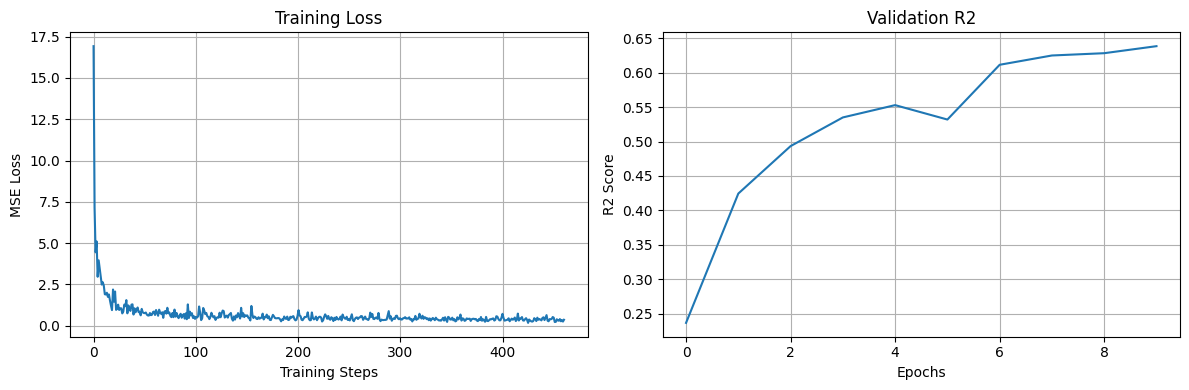

In [9]:
# Visualize the results
plot_training_curves(poyo_motor_r2, poyo_motor_loss)

In [10]:
# Save the finetuned model
model_motor.save_checkpoint(checkpoint_path="poyo_motor.ckpt")

## Train a model with Caudoputamen units

Finetuning Progress: 100%|███████████████████████████████████████| 10/10 [06:07<00:00, 36.80s/it, Avg Loss=0.3526, Val R2=0.580]



✅ Done! Final validation R² = 0.617


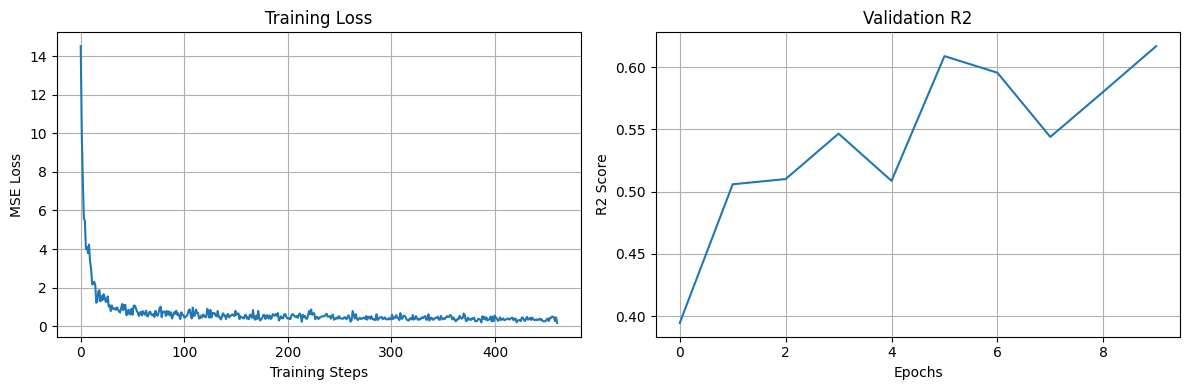

In [11]:
# Load pre-trained weights
model_caudoputamen = load_model(checkpoint="poyo_1.ckpt")

filter_str = ["caudoputamen"]
min_quality_score = 0.6

# Reinitialize the vocabs for the new units and sessions
units_ids = get_unit_ids(
    dataset=train_dataset,
    filter_str=filter_str,
    quality_score=min_quality_score,
)

try:
    model_caudoputamen.unit_emb.extend_vocab(units_ids)
    model_caudoputamen.unit_emb.subset_vocab(units_ids)
    
    model_caudoputamen.session_emb.extend_vocab(train_dataset.get_session_ids())
    model_caudoputamen.session_emb.subset_vocab(train_dataset.get_session_ids())
except Exception as e:
    print(e)

# Connect tokenizers to Datasets
train_dataset.transform = Transform(model=model_caudoputamen)
val_dataset.transform = Transform(model=model_caudoputamen)

# Setup Optimizer
optimizer = torch.optim.AdamW(model_caudoputamen.parameters(), lr=1e-3)

# Finetune
poyo_caudoputamen_r2, poyo_caudoputamen_loss, poyo_caudoputamen_train_outputs = finetune(
    model_caudoputamen,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=10,
    epoch_to_unfreeze=-1,
)

# Visualize the results
plot_training_curves(poyo_caudoputamen_r2, poyo_caudoputamen_loss)

# Save the finetuned model
model_caudoputamen.save_checkpoint(checkpoint_path="poyo_caudoputamen.ckpt")

# Train a model with Motor Cortex + Caudoputamen units

Finetuning Progress: 100%|███████████████████████████████████████| 10/10 [07:16<00:00, 43.67s/it, Avg Loss=0.2809, Val R2=0.663]



✅ Done! Final validation R² = 0.662


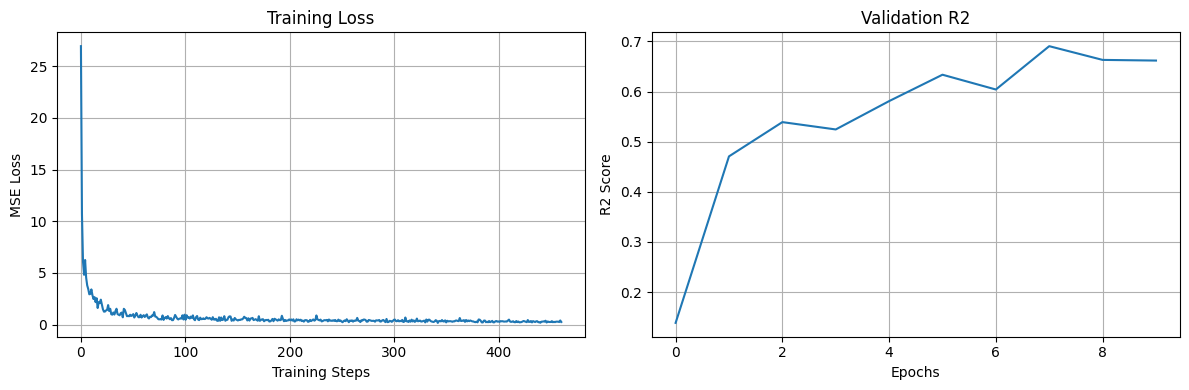

In [12]:
# Load pre-trained weights
model_both = load_model(checkpoint="poyo_1.ckpt")

filter_str = [
    "motor",
    "caudoputamen",
]
min_quality_score = 0.6

# Reinitialize the vocabs for the new units and sessions
units_ids = get_unit_ids(
    dataset=train_dataset,
    filter_str=filter_str,
    quality_score=min_quality_score,
)
try:
    model_both.unit_emb.extend_vocab(units_ids)
    model_both.unit_emb.subset_vocab(units_ids)
    
    model_both.session_emb.extend_vocab(train_dataset.get_session_ids())
    model_both.session_emb.subset_vocab(train_dataset.get_session_ids())
except Exception as e:
    print(e)

# Connect tokenizers to Datasets
train_dataset.transform = Transform(model=model_both)
val_dataset.transform = Transform(model=model_both)

# Setup Optimizer
optimizer = torch.optim.AdamW(model_both.parameters(), lr=1e-3)

# Finetune
poyo_both_r2, poyo_both_loss, poyo_both_train_outputs = finetune(
    model_both,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=10,
    epoch_to_unfreeze=-1,
)

# Visualize the results
plot_training_curves(poyo_both_r2, poyo_both_loss)

# Save the finetuned model
model_both.save_checkpoint(checkpoint_path="poyo_both.ckpt")

## Run inference against Test set

In [13]:
test_motor = run_test(
    test_dataset,
    test_loader,
    model_motor,
)

test_caudoputamen = run_test(
    test_dataset,
    test_loader,
    model_caudoputamen,
)

test_both = run_test(
    test_dataset,
    test_loader,
    model_both,
)

test_results = dict(
    motor=test_motor,
    caudoputamen=test_caudoputamen,
    both=test_both,
)

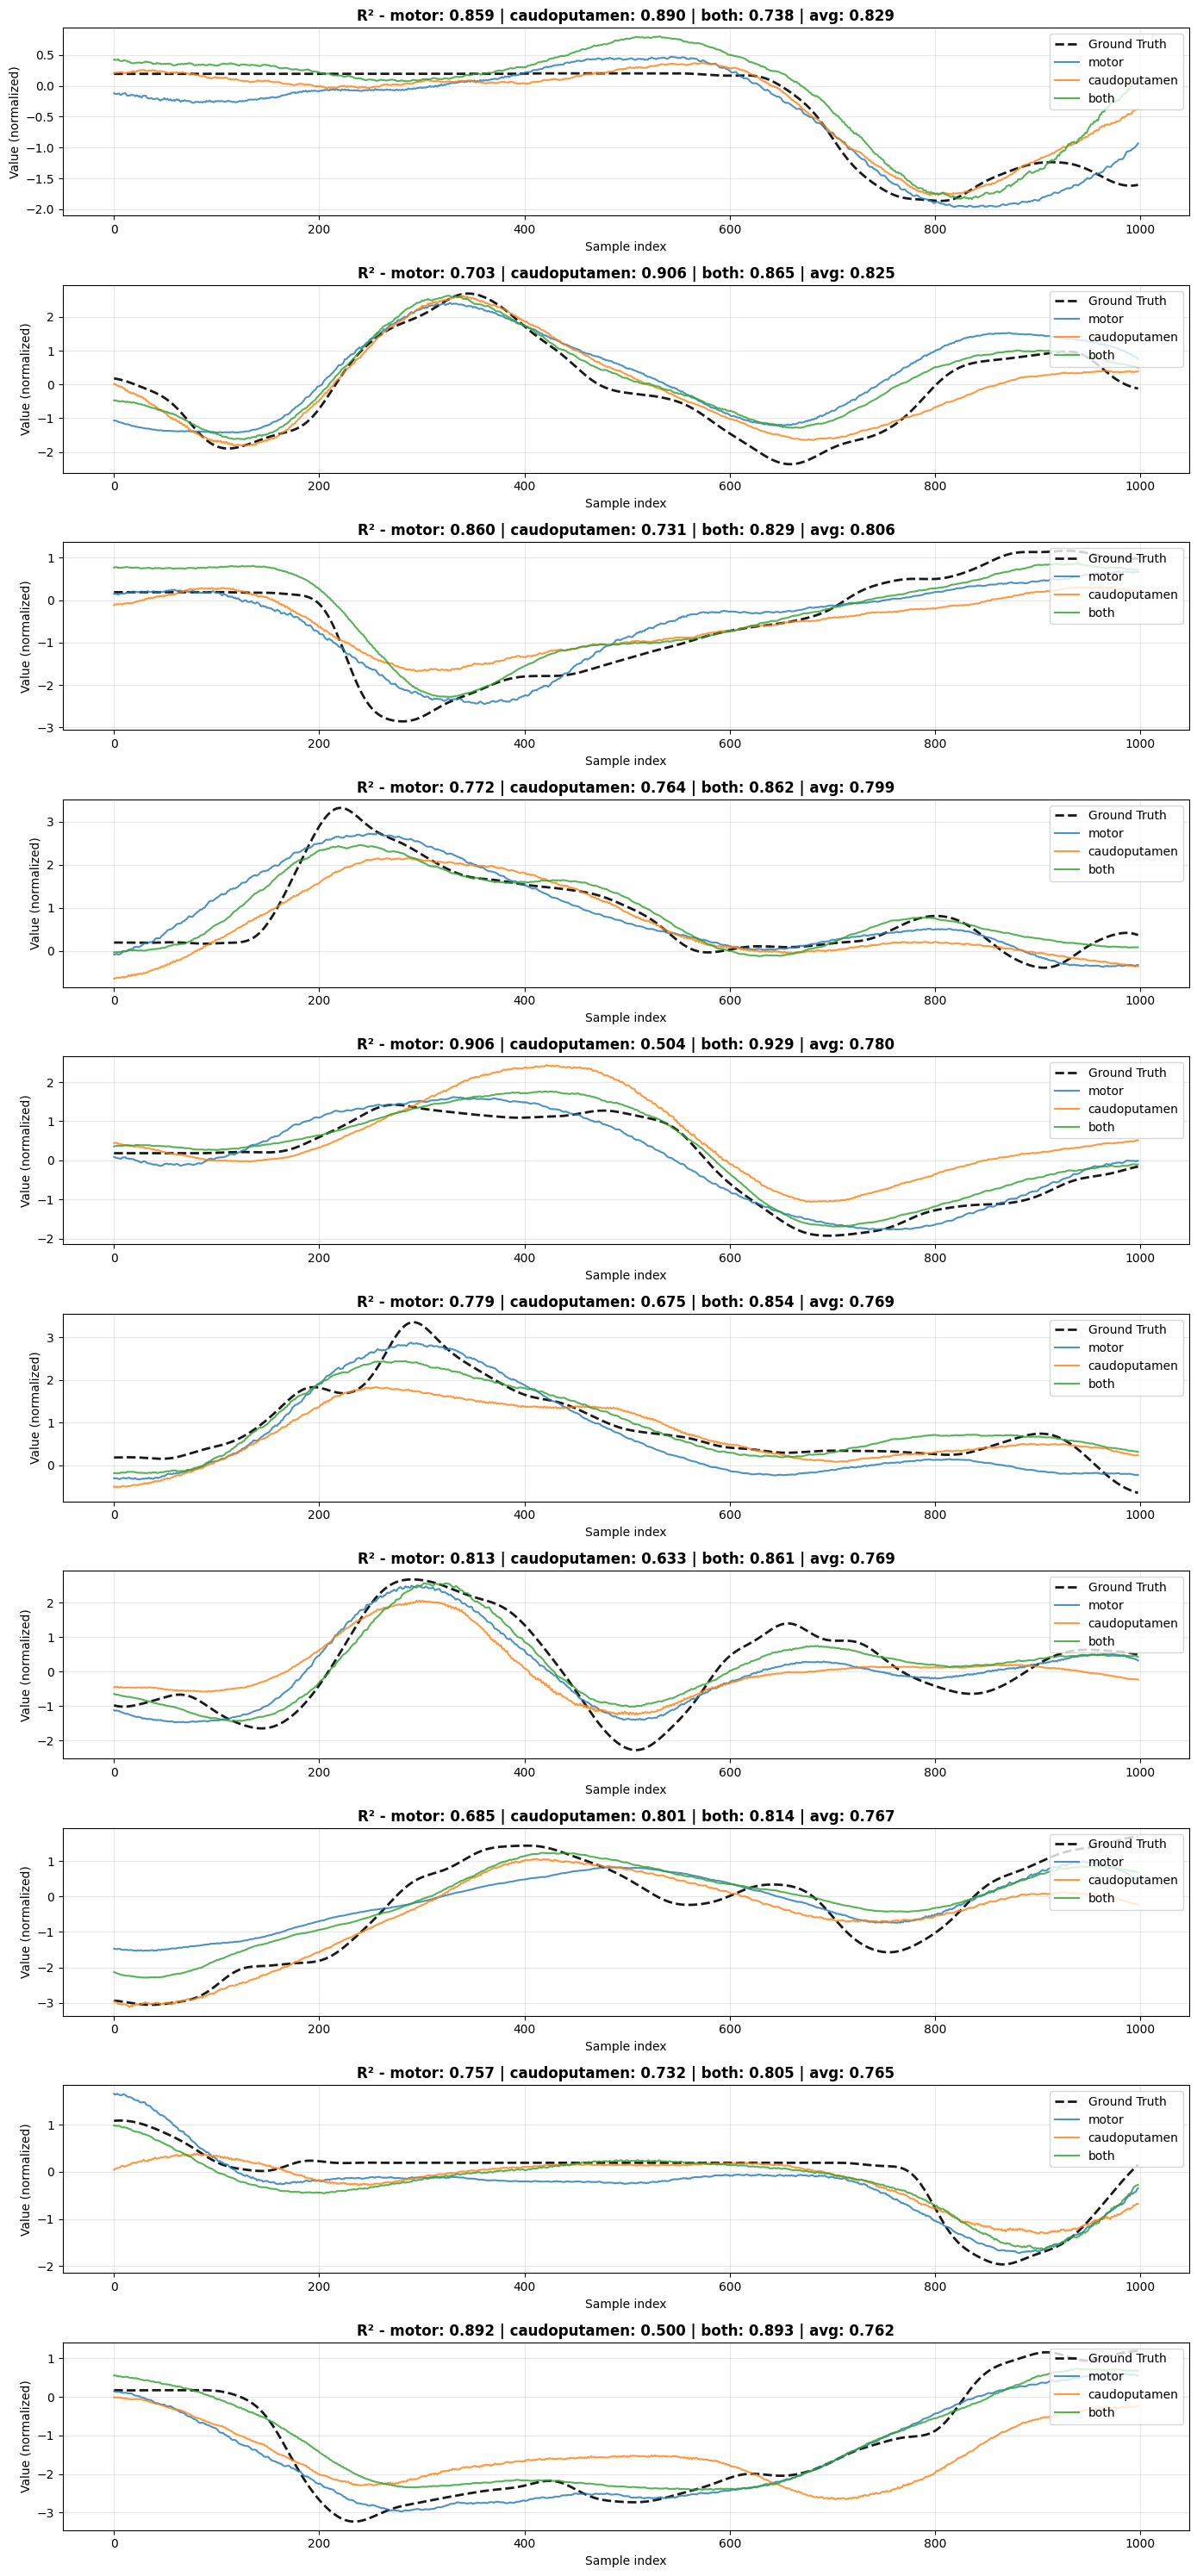

In [14]:
plot_test_intervals(
    test_results=test_results,
    n_intervals=10,
    order="top",
)

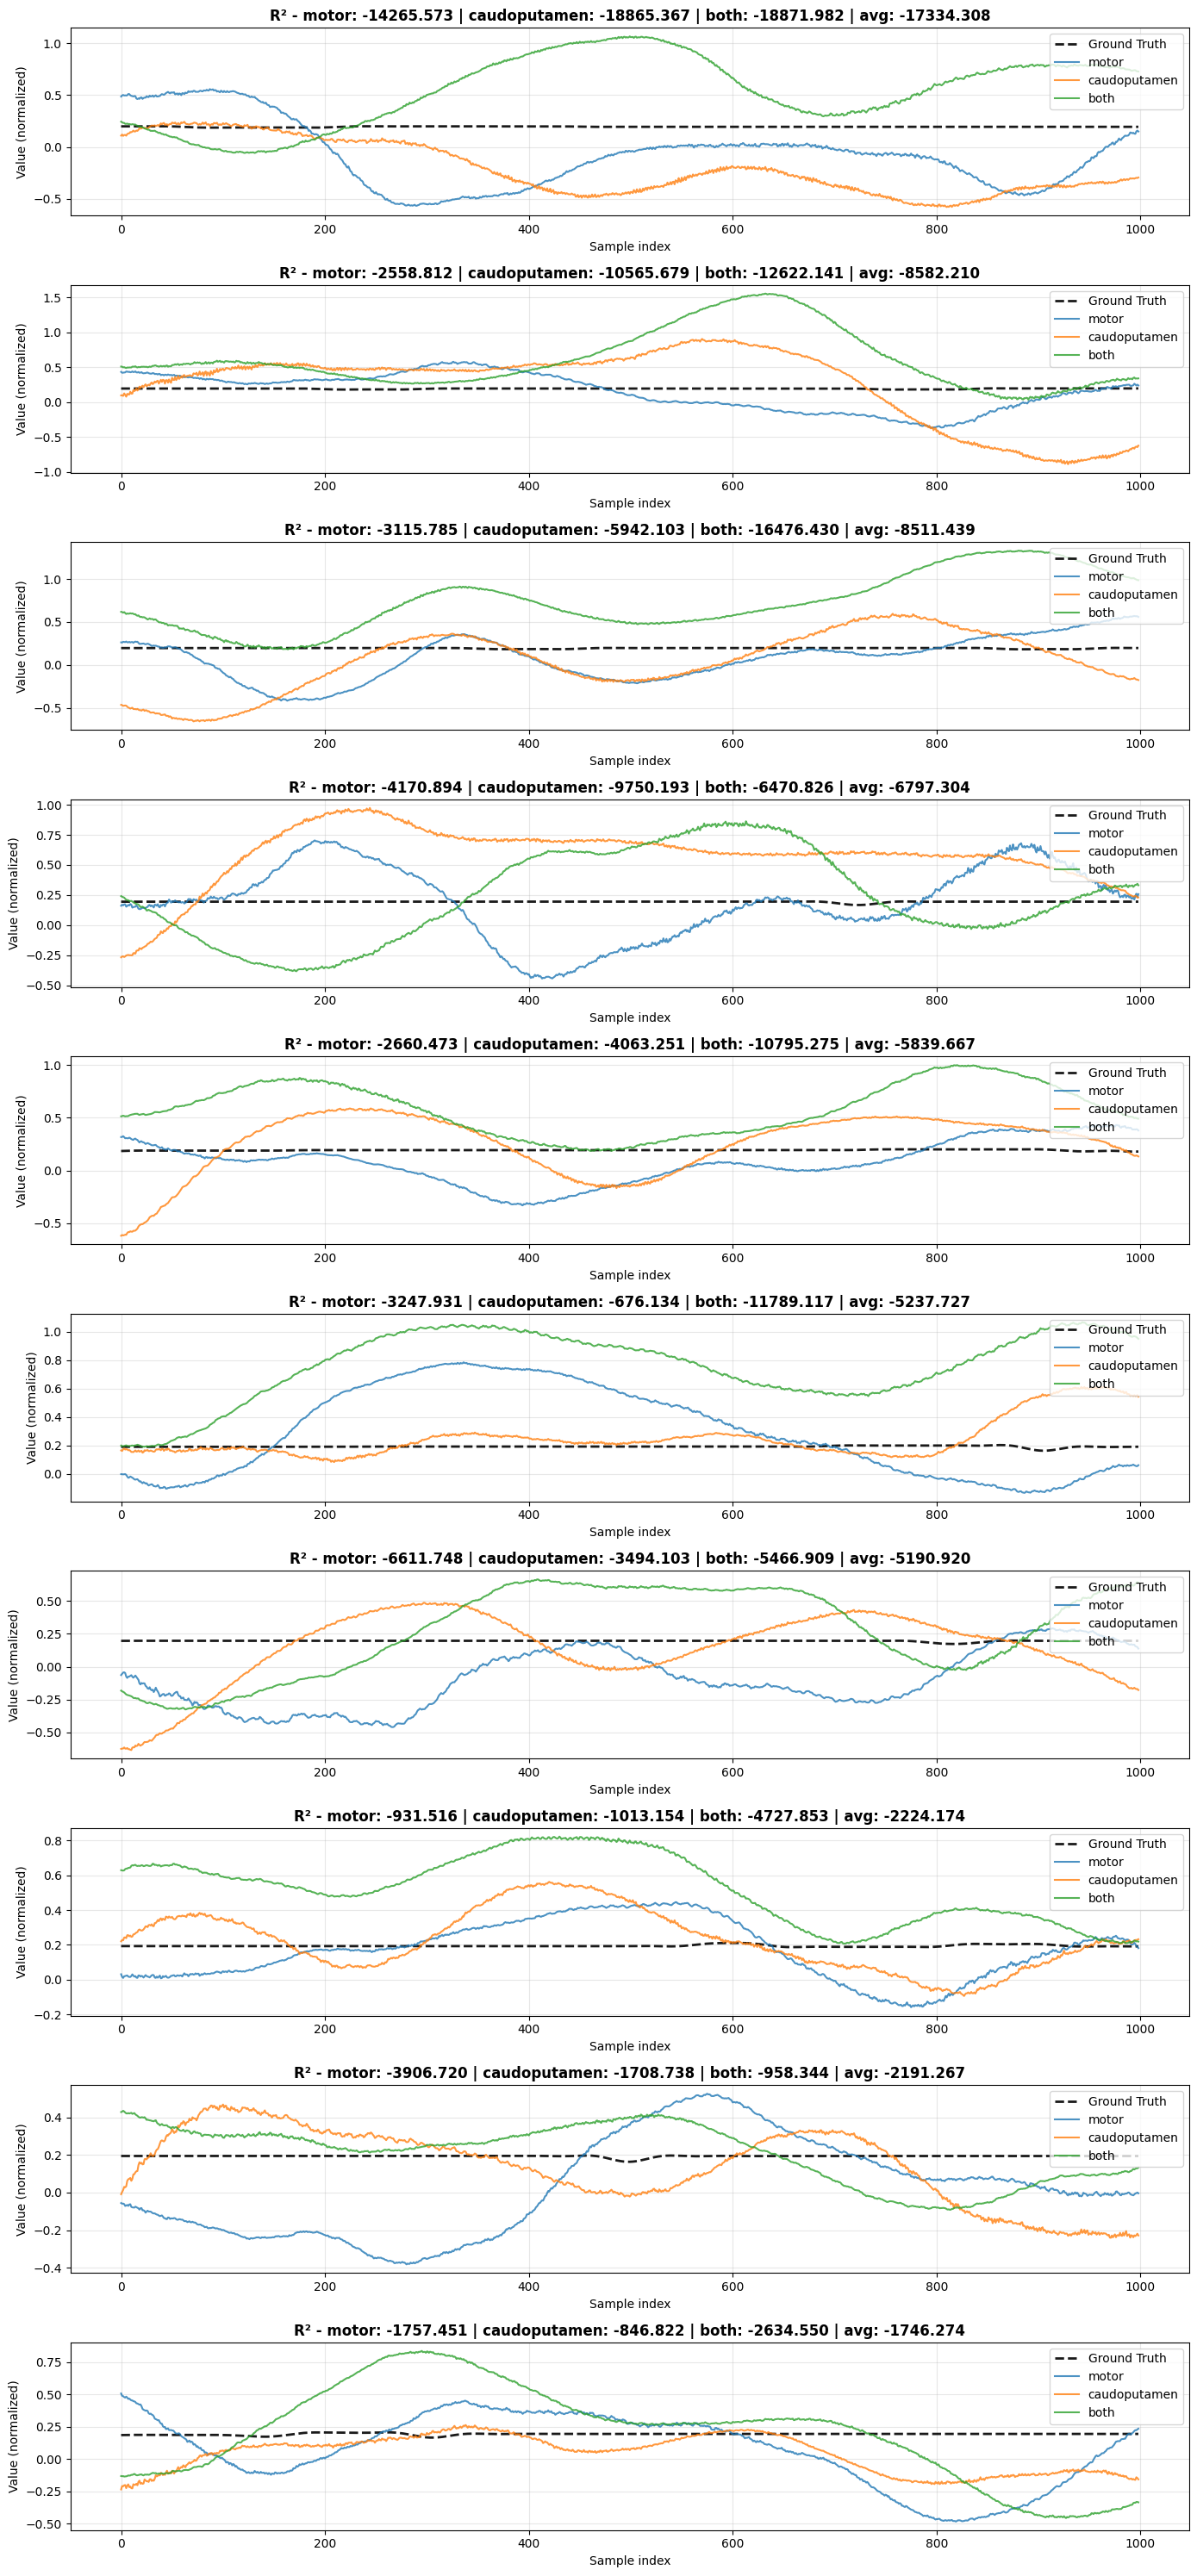

In [15]:
plot_test_intervals(
    test_results=test_results,
    n_intervals=10,
    order="bottom",
)